In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import keras
from keras.layers import Dense, Activation
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.statespace.sarimax import SARIMAX

# fix random seed for reproducibility
np.random.seed(7)

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


The below code predicts the time series data for a complicated function with varying frequencies and altitudes using an LSTM model

Epoch 1/100
 - 5s - loss: 0.0068
Epoch 2/100
 - 5s - loss: 4.1645e-05
Epoch 3/100
 - 5s - loss: 4.1804e-05
Epoch 4/100
 - 5s - loss: 3.9632e-05
Epoch 5/100
 - 5s - loss: 3.8431e-05
Epoch 6/100
 - 5s - loss: 3.4797e-05
Epoch 7/100
 - 5s - loss: 3.4617e-05
Epoch 8/100
 - 5s - loss: 3.4133e-05
Epoch 9/100
 - 5s - loss: 3.2828e-05
Epoch 10/100
 - 5s - loss: 3.1025e-05
Epoch 11/100
 - 5s - loss: 3.2158e-05
Epoch 12/100
 - 5s - loss: 3.1487e-05
Epoch 13/100
 - 5s - loss: 3.0723e-05
Epoch 14/100
 - 5s - loss: 3.1030e-05
Epoch 15/100
 - 5s - loss: 2.9443e-05
Epoch 16/100
 - 5s - loss: 2.7943e-05
Epoch 17/100
 - 5s - loss: 2.9284e-05
Epoch 18/100
 - 5s - loss: 2.8173e-05
Epoch 19/100
 - 5s - loss: 2.8735e-05
Epoch 20/100
 - 5s - loss: 2.8308e-05
Epoch 21/100
 - 5s - loss: 2.7107e-05
Epoch 22/100
 - 5s - loss: 2.6610e-05
Epoch 23/100
 - 5s - loss: 2.7230e-05
Epoch 24/100
 - 5s - loss: 2.6387e-05
Epoch 25/100
 - 5s - loss: 2.6771e-05
Epoch 26/100
 - 5s - loss: 2.6229e-05
Epoch 27/100
 - 5s - loss

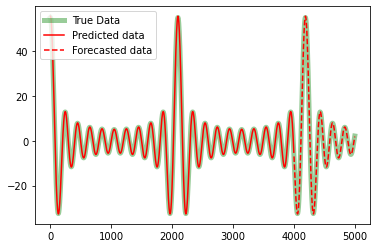

In [3]:
N = 5000
X = np.linspace(0, 15, N)
Y = 10*(np.cos(10*X)) + 9*(np.cos(9*X)) + 8*(np.cos(8*X)) + \
7*(np.cos(7*X)) + 6*(np.cos(6*X)) + 5*(np.cos(5*X)) + 4*(np.cos(4*X)) +\
3*(np.cos(3*X)) + 2*(np.cos(2*X)) + np.cos(X)
dataset = Y.reshape(Y.size, 1)

scaler = MinMaxScaler(feature_range=(0, 1)) #Ask about this
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)


look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)


trainPredict = model.predict(trainX)
testPredict = model.predict(testX)


trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])


trainScore = sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

plt.plot(scaler.inverse_transform(dataset), 'g', linewidth=5, alpha=0.4, label='True Data')
plt.plot(trainPredictPlot, color = 'red', label = 'Predicted data')
plt.plot(testPredictPlot, '--' , color = 'red', label = 'Forecasted data')
plt.legend()
plt.show()

The below code predicts the time series data for a complicated function with varying frequencies and altitudes using an SARIMA model


In [8]:
# grid search sarima hyperparameters
from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

N = 5000
X = np.linspace(0, 15, N)
Y = 10*(np.cos(10*X)) + 9*(np.cos(9*X)) + 8*(np.cos(8*X)) + \
7*(np.cos(7*X)) + 6*(np.cos(6*X)) + 5*(np.cos(5*X)) + 4*(np.cos(4*X)) +\
3*(np.cos(3*X)) + 2*(np.cos(2*X)) + np.cos(X)
dataset = Y.reshape(Y.size, 1)

# one-step sarima forecast
def sarima_forecast(history, config):
	order, sorder, trend = config
	# define model
	model = SARIMAX(history, order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
	# fit model
	model_fit = model.fit(disp=False)
	# make one step forecast
	yhat = model_fit.predict(len(history), len(history))
	return yhat[0]

# root mean squared error or rmse
def measure_rmse(actual, predicted):
	return sqrt(mean_squared_error(actual, predicted))

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# fit model and make forecast for history
		yhat = sarima_forecast(history, cfg)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
	# estimate prediction error
	error = measure_rmse(test, predictions)
	return error

# score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
	result = None
	# convert config to a key
	key = str(cfg)
	# show all warnings and fail on exception if debugging
	if debug:
		result = walk_forward_validation(data, n_test, cfg)
	else:
		# one failure during model validation suggests an unstable config
		try:
			# never show warnings when grid searching, too noisy
			with catch_warnings():
				filterwarnings("ignore")
				result = walk_forward_validation(data, n_test, cfg)
		except:
			error = None
	# check for an interesting result
	if result is not None:
		print(' > Model[%s] %.3f' % (key, result))
	return (key, result)

# grid search configs
def grid_search(data, cfg_list, n_test, parallel=True):
	scores = None
	if parallel:
		# execute configs in parallel
		executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
		tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list)
		scores = executor(tasks)
	else:
		scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
	# remove empty results
	scores = [r for r in scores if r[1] != None]
	# sort configs by error, asc
	scores.sort(key=lambda tup: tup[1])
	return scores

# create a set of sarima configs to try
def sarima_configs(seasonal=[0]):
	models = list()
	# define config lists
	p_params = [0, 1, 2]
	d_params = [0, 1]
	q_params = [0, 1, 2]
	t_params = ['n','c','t','ct']
	P_params = [0, 1, 2]
	D_params = [0, 1]
	Q_params = [0, 1, 2]
	m_params = seasonal
	# create config instances
	for p in p_params:
		for d in d_params:
			for q in q_params:
				for t in t_params:
					for P in P_params:
						for D in D_params:
							for Q in Q_params:
								for m in m_params:
									cfg = [(p,d,q), (P,D,Q,m), t]
									models.append(cfg)
	return models

if __name__ == '__main__':
	# define dataset
	data = Y
	print(data)
	# data split
	n_test = 4000
	# model configs
	cfg_list = sarima_configs()
	# grid search
	scores = grid_search(data, cfg_list, n_test)
	print('done')
	# list top 3 configs
	for cfg, error in scores[:3]:
		print(cfg, error)

[55.         54.9863828  54.94554015 ...  1.76845525  1.93035671
  2.08989565]
 > Model[[(0, 0, 0), (0, 0, 0, 0), 'n']] 14.171


KeyboardInterrupt: ignored